## 1. Config

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from preprocessing.imputers import SimpleImputerDF
from preprocessing.feature_extraction import FeatureExtractor
from preprocessing.transformers import OneHotEncoderDF, LogTransformerDF, OrdinalEncoderDF

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from models.datasets import UsersProfilesDataset
from models.models import ProfileClassifier

from sklearn.metrics import mean_squared_error

import torch

In [2]:
DATA_DIRECTORY = './data'
PERSONALITY_FILE_PATH = os.path.join(DATA_DIRECTORY, 'data science task personality.csv')
USERS_FILE_PATH = os.path.join(DATA_DIRECTORY, 'data science task users.csv')

RANDOM_STATE = 42

TEST_SIZE = 0.2

## 2. Data loading

In [3]:
df_p = pd.read_csv(PERSONALITY_FILE_PATH)

df_p.head()

,UserIdentifier,A,B,C,D,E
0,d2d10f362bb1d0092174a660778cbe50,0.041197,-0.389188,-0.257404,0.732678,-0.769127
1,083a56a91d0d1ee4e66643849133b2b3,-0.596461,0.620304,-0.611045,-0.256928,-0.244441
2,fdc1004b329f2aca4c81ad59c93c1be0,-1.198166,-0.821102,0.298394,-0.031738,0.821793
3,8b8a4372a0f3fd3e1a1d4c531211506e,-0.344910,-1.611630,0.220709,-0.323851,-0.127276
4,58d0c701bf73a5949e2ee29f387fb5a2,-0.365047,1.094319,-0.187957,-0.254589,0.554409


In [4]:
df_u = pd.read_csv(USERS_FILE_PATH)

df_u.head()

,UserIdentifier,UserBrowser,D01,D02,D03,D04,D05,D06,D07
0,d2d10f362bb1d0092174a660778cbe50,Firefox 69.0 (Desktop),M,1954.0,3.0,4.0,2.0,6.0,2.0
1,083a56a91d0d1ee4e66643849133b2b3,Chrome 70.0.3538.110 (Mobile),M,1963.0,2.0,2.0,2.0,7.0,2.0
2,fdc1004b329f2aca4c81ad59c93c1be0,Chrome 77.0.3865.90 (Desktop),K,1975.0,4.0,1.0,4.0,5.0,6.0
3,8b8a4372a0f3fd3e1a1d4c531211506e,Chrome 75.0.3770.142 (Desktop),K,1991.0,3.0,2.0,4.0,5.0,4.0
4,58d0c701bf73a5949e2ee29f387fb5a2,Chrome 78.0.3904.108 (Mobile),M,2000.0,3.0,3.0,1.0,7.0,6.0


## 3. Base data quality checks

In [5]:
print(f'DataFrame personality: \n', 30*'-')
print(f'shape: {df_p.shape}')
print(f'distinct UserIdentifier: {len(set(df_p.UserIdentifier))}')
print(f'null values: \n{np.sum(df_p.isnull())}')

print(f'\nDataFrame users: \n', 30*'-')
print(f'shape: {df_u.shape}')
print(f'distinct UserIdentifier: {len(set(df_u.UserIdentifier))}')
print(f'null values: \n{np.sum(df_u.isnull())}')

DataFrame personality: 
 ------------------------------
shape: (1681, 6)
distinct UserIdentifier: 1521
null values: 
UserIdentifier     0
A                  4
B                 10
C                 13
D                  5
E                  5
dtype: int64

DataFrame users: 
 ------------------------------
shape: (1868, 9)
distinct UserIdentifier: 1679
null values: 
UserIdentifier    0
UserBrowser       0
D01               0
D02               0
D03               0
D04               0
D05               1
D06               1
D07               1
dtype: int64


## 4. Preprocessing

### 4.1 Drop duplicates

In [6]:
df_p_unique = df_p.drop_duplicates(keep='first').set_index('UserIdentifier')
df_u_unique = df_u.drop_duplicates(keep='first').set_index('UserIdentifier')

### 4.2 Merge sets

In [7]:
df_all = pd.merge(
    left=df_u_unique,
    right=df_p_unique,
    how='left',
    left_index=True,
    right_index=True
)
df_all.shape

(1695, 13)

In [8]:
df_all[df_all.isnull().any(axis=1)]

,UserBrowser,D01,D02,D03,D04,D05,D06,D07,A,B,C,D,E
UserIdentifier,,,,,,,,,,,,,
007079c718eff3683d244e6bceb67f35,Firefox 71.0 (Desktop),K,1968.0,3.0,2.0,1.0,7.0,3.0,NaN,NaN,NaN,NaN,NaN
00e33b78167c8685d643895b637bd462,Chrome 77.0.3865.90 (Desktop),M,1974.0,4.0,2.0,5.0,6.0,2.0,NaN,NaN,NaN,NaN,NaN
021c9be32665a83b806ab5a07f140c46,Chrome 78.0.3904.108 (Mobile),M,1981.0,3.0,2.0,4.0,10.0,2.0,NaN,NaN,NaN,NaN,NaN
02cf10f9afb8c7c6f5d5c5983788185a,Chrome 79.0.3945.130 (Desktop),M,1997.0,4.0,2.0,4.0,7.0,3.0,NaN,NaN,NaN,NaN,NaN
04faae14580b8db0962e85991a9114ba,Chrome 78.0.3904.108 (Desktop),K,1982.0,3.0,1.0,4.0,10.0,6.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
fb21c4d442ad5939bee4257679eb63ac,Chrome 80.0.3987.87 (Mobile),K,1995.0,3.0,6.0,1.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN
fb551347615ac13f503482196a2ee8d9,Chrome 71.0.3578.99 (Mobile),K,1993.0,3.0,3.0,1.0,8.0,3.0,NaN,NaN,NaN,NaN,NaN
fe752ba7a82ba3275adb99471912038c,Chrome 78.0.3904.108 (Mobile),M,1991.0,4.0,2.0,4.0,6.0,3.0,NaN,NaN,NaN,NaN,NaN


### 4.3 Train/test split

In [9]:
users_train, users_test, profiles_train, profiles_test = train_test_split(
    df_all[df_u_unique.columns],
    df_all[df_p_unique.columns],
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE
)

### 4.4 Data imputation

In [10]:
profiles_train[profiles_train.isnull().any(axis=1)]

,A,B,C,D,E
UserIdentifier,,,,,
6752362b8c7a9a90f54419ee610798e2,NaN,NaN,NaN,NaN,NaN
d86a7c34221256b8a368066de6ce1f52,NaN,NaN,NaN,NaN,NaN
574c63403d610abdcaf84020a38cbd04,NaN,NaN,NaN,NaN,NaN
fa50c6662943de3ade10378cf74ffd50,NaN,NaN,NaN,NaN,NaN
07bdb7bd96871fa49af5650ae7507867,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
e036fce4a27b3b658ff394100c4b7661,NaN,0.361130,-0.056259,0.113367,-0.229832
ee7889cb44e0a690fc75227219529312,NaN,NaN,NaN,NaN,NaN
b452b360dbd9901b36a8a225ecc820e1,NaN,NaN,NaN,NaN,NaN


In [11]:
imputer_profiles = SimpleImputerDF(strategy='constant', fill_value_num=0.0)

profiles_train = imputer_profiles.fit_transform(profiles_train) 

In [12]:
users_train[users_train.isnull().any(axis=1)]

,UserBrowser,D01,D02,D03,D04,D05,D06,D07
UserIdentifier,,,,,,,,
afe841be2dababac5a440e0c14a9f903,Chrome 78.0.3904.108 (Mobile),K,1981.0,4.0,2.0,NaN,NaN,NaN


In [13]:
imputer_users = SimpleImputerDF(strategy='constant', fill_value_num=-1.0)

users_train = imputer_users.fit_transform(users_train)

## 5. Preprocessing

### 5.1 Config

In [14]:
feature_list_freq_encoding = [
    'browser_version'
]
feature_list_one_hot_encoding = [
    'D01',
    'D03',
    'D04',
    'D05',
    'browser_name',
    'device_type'
]
feature_list_log_scaling = [
    'D06',
    'D07',
    'age'
]

### 5.2 Extraction of features

In [15]:
feature_extractor = FeatureExtractor(n_jobs=-1)
users_train = feature_extractor.fit_transform(users_train)

users_train.head()

,D01,D03,D04,D05,D06,D07,browser_name,browser_version,device_type,age
UserIdentifier,,,,,,,,,,
6752362b8c7a9a90f54419ee610798e2,K,4.0,2.0,2.0,5.0,2.0,Chrome,78.00039,Mobile,53
c84e93e811adfa031ae4254dddb797f5,K,3.0,4.0,2.0,2.0,1.0,Firefox,52.00000,Desktop,72
5a94f488ddf508fec534ecb91f3d7a05,K,4.0,2.0,3.0,8.0,3.0,Firefox,52.00000,Desktop,42
99d5bfc07d78c0dea2330be4e2427a85,K,4.0,3.0,1.0,8.0,3.0,Chrome,78.00039,Mobile,29
d89368a53b1fc5082d0222e1bd71ad15,K,3.0,2.0,3.0,6.0,3.0,Chrome,78.00039,Desktop,26


### 5.3 Brief EDA of features

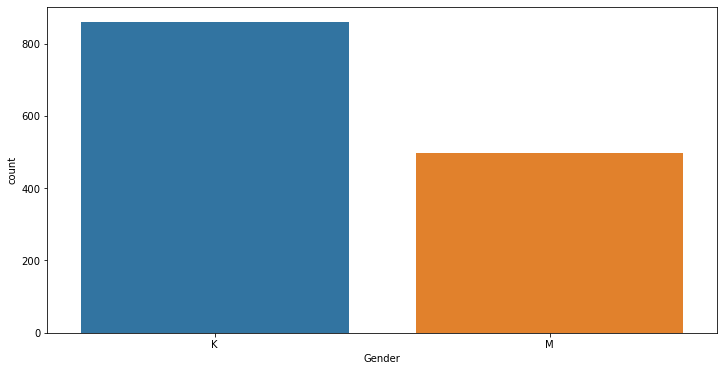

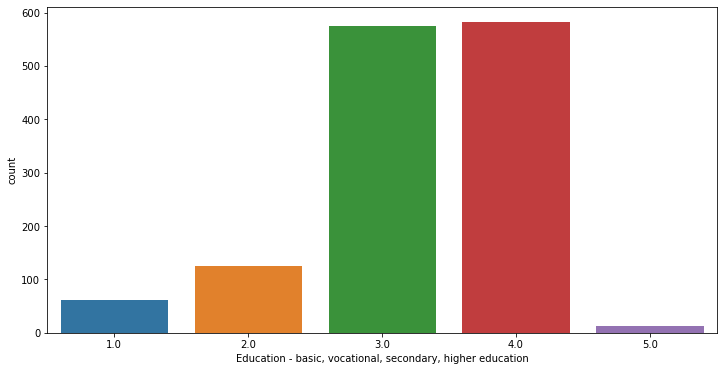

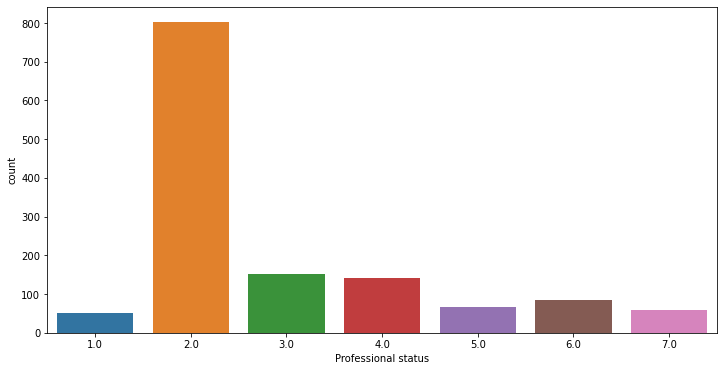

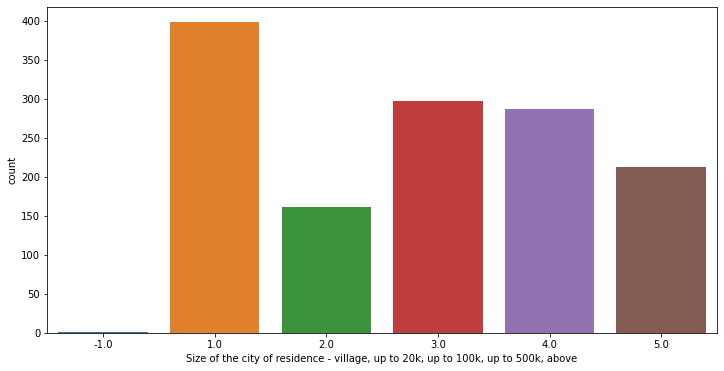

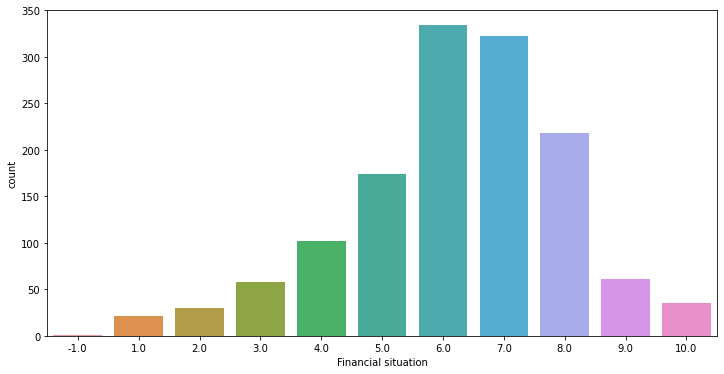

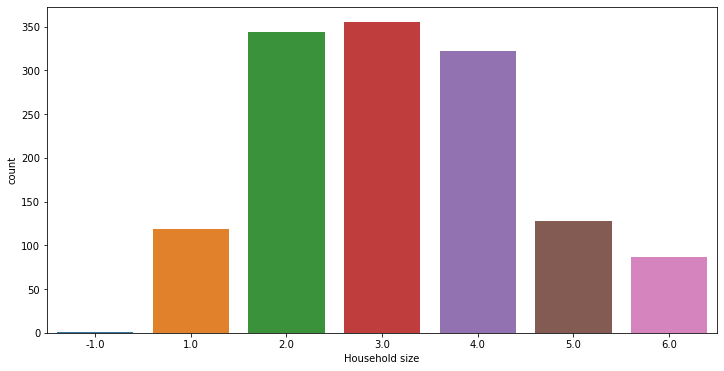

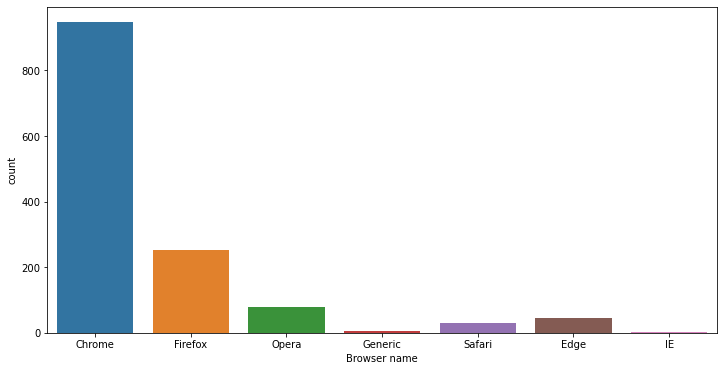

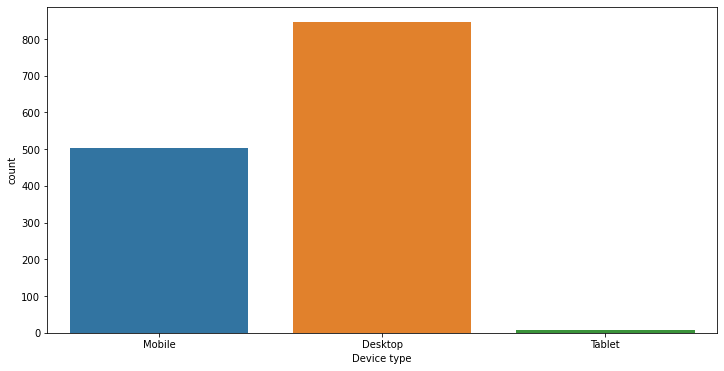

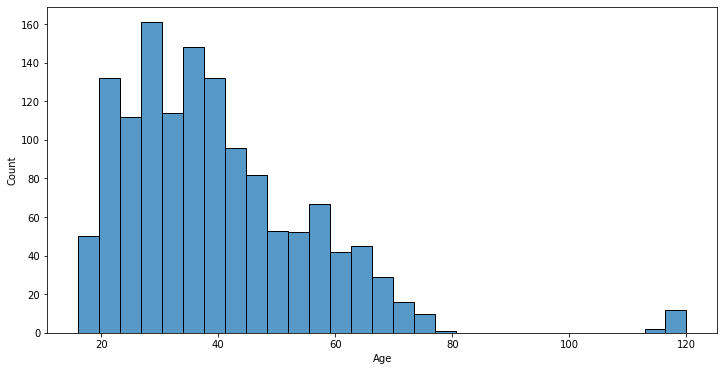

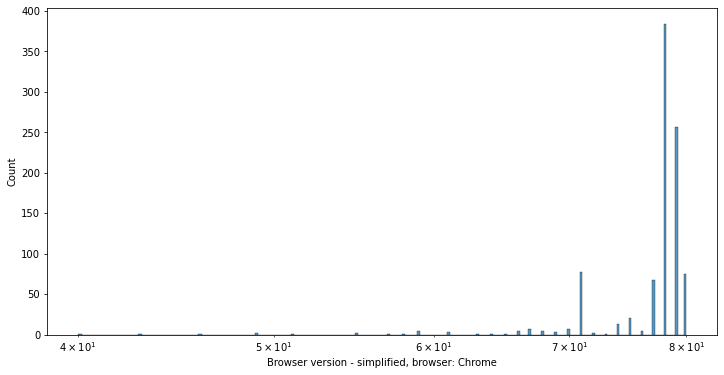

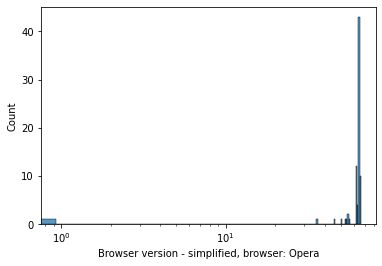

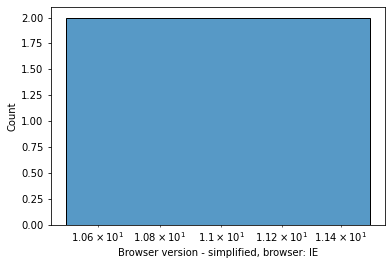

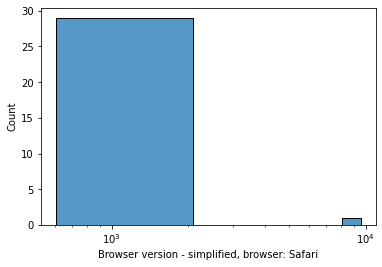

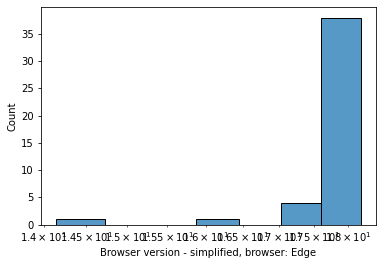

In [16]:
col_config = {
    'categorical': {
        'D01': 'Gender',
        'D03': 'Education - basic, vocational, secondary, higher education',
        'D04': 'Professional status',
        'D05': 'Size of the city of residence - village, up to 20k, up to 100k, up to 500k, above',
        'D06': 'Financial situation',
        'D07': 'Household size',
        'browser_name': 'Browser name',
        'device_type': 'Device type'
    },
    'continuous': {
        'age': 'Age',
        'browser_version': 'Browser version - simplified'
    }
}

for col_name, col_desc in col_config['categorical'].items():
    plt.figure(figsize=(12, 6))
    sns.countplot(
        data=users_train,
        x=col_name
    )
    plt.xlabel(col_desc)
    
for col_name, col_desc in col_config['continuous'].items():
    plt.figure(figsize=(12, 6))
    plt.xlabel(col_desc)
    
    if col_name == 'age':
        sns.histplot(
            data=users_train,
            x=col_name
        )
    elif col_name == 'browser_version':
        for browser in ['Chrome', 'Opera', 'IE', 'Safari', 'Edge']: # set(users_train.browser_name) = ['Opera', 'IE', 'Safari', 'Edge', 'Generic']
            sns.histplot(
                data=users_train[(users_train['browser_name'] == browser)],
                x=col_name,
            )
            plt.xscale('log')
            plt.xlabel(f'{col_desc}, browser: {browser}')
            plt.show()

### 5.4 Ordinal encoding of browser version

In [17]:
ordinal_encoder = OrdinalEncoderDF(['device_type', 'browser_name'], 'browser_version')
users_train = ordinal_encoder.fit_transform(users_train)

users_train.head()

,D01,D03,D04,D05,D06,D07,browser_name,device_type,age,browser_version_rank
UserIdentifier,,,,,,,,,,
6752362b8c7a9a90f54419ee610798e2,K,4.0,2.0,2.0,5.0,2.0,Chrome,Mobile,53,11.0
c84e93e811adfa031ae4254dddb797f5,K,3.0,4.0,2.0,2.0,1.0,Firefox,Desktop,72,10.0
5a94f488ddf508fec534ecb91f3d7a05,K,4.0,2.0,3.0,8.0,3.0,Firefox,Desktop,42,10.0
99d5bfc07d78c0dea2330be4e2427a85,K,4.0,3.0,1.0,8.0,3.0,Chrome,Mobile,29,11.0
d89368a53b1fc5082d0222e1bd71ad15,K,3.0,2.0,3.0,6.0,3.0,Chrome,Desktop,26,15.0


### 5.5 One-Hot encoding

In [18]:
onehot_encoder = OneHotEncoderDF(feature_list_one_hot_encoding)
users_train = onehot_encoder.fit_transform(users_train)

users_train.head()

,D06,D07,age,browser_version_rank,d01_k,d01_m,d03_1_0,d03_2_0,d03_3_0,d03_4_0,...,browser_name_chrome,browser_name_edge,browser_name_firefox,browser_name_generic,browser_name_ie,browser_name_opera,browser_name_safari,device_type_desktop,device_type_mobile,device_type_tablet
UserIdentifier,,,,,,,,,,,,,,,,,,,,,
6752362b8c7a9a90f54419ee610798e2,5.0,2.0,53,11.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
c84e93e811adfa031ae4254dddb797f5,2.0,1.0,72,10.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5a94f488ddf508fec534ecb91f3d7a05,8.0,3.0,42,10.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
99d5bfc07d78c0dea2330be4e2427a85,8.0,3.0,29,11.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
d89368a53b1fc5082d0222e1bd71ad15,6.0,3.0,26,15.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### 5.6 Log transformation

In [19]:
# Save non-transformed version for clustering of psychological profiles
users_train_not_transformed = users_train.copy()

log_transformer = LogTransformerDF(feature_list_log_scaling)
users_train = log_transformer.fit_transform(users_train)

users_train.head()

,browser_version_rank,d01_k,d01_m,d03_1_0,d03_2_0,d03_3_0,d03_4_0,d03_5_0,d04_1_0,d04_2_0,...,browser_name_generic,browser_name_ie,browser_name_opera,browser_name_safari,device_type_desktop,device_type_mobile,device_type_tablet,D06_log,D07_log,age_log
UserIdentifier,,,,,,,,,,,,,,,,,,,,,
6752362b8c7a9a90f54419ee610798e2,11.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.945910,1.386294,3.637586
c84e93e811adfa031ae4254dddb797f5,10.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.386294,1.098612,4.043051
5a94f488ddf508fec534ecb91f3d7a05,10.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.302585,1.609438,3.295837
99d5bfc07d78c0dea2330be4e2427a85,11.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.302585,1.609438,2.639057
d89368a53b1fc5082d0222e1bd71ad15,15.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.079442,1.609438,2.397895


### 5.7 Transform test dataset

In [20]:
# Profiles
profiles_test = imputer_profiles.transform(profiles_test)

# Users
users_test = imputer_users.transform(users_test)
users_test = feature_extractor.transform(users_test)
users_test = ordinal_encoder.transform(users_test)
users_test = onehot_encoder.transform(users_test)

# Save non-transformed version for clustering of psychological profiles
users_test_not_transformed = users_test.copy()

# Apply log-transform
users_test = log_transformer.transform(users_test)

users_test.head()

,browser_version_rank,d01_k,d01_m,d03_1_0,d03_2_0,d03_3_0,d03_4_0,d03_5_0,d04_1_0,d04_2_0,...,browser_name_generic,browser_name_ie,browser_name_opera,browser_name_safari,device_type_desktop,device_type_mobile,device_type_tablet,D06_log,D07_log,age_log
UserIdentifier,,,,,,,,,,,,,,,,,,,,,
89f970118311aca77a98f4a18f163726,15.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.302585,1.098612,3.465736
d09a98da4db82b1939e3183ddb1f8e69,11.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.397895,1.386294,2.484907
ea7a103e859ef8718e244b81f7384b20,15.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.945910,1.386294,3.912023
94e3018710af7b51e95c6243ee6cc224,11.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.197225,1.386294,3.258097
47bbe37bab5252eddf884b9d4ce6e3f0,11.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.302585,1.945910,3.218876


## 6. 2D visualization of data

### 6.1 Users

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1356 samples in 0.003s...
[t-SNE] Computed neighbors for 1356 samples in 0.109s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1356
[t-SNE] Computed conditional probabilities for sample 1356 / 1356
[t-SNE] Mean sigma: 0.814795
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.072212
[t-SNE] KL divergence after 1000 iterations: 0.844946


<AxesSubplot:>

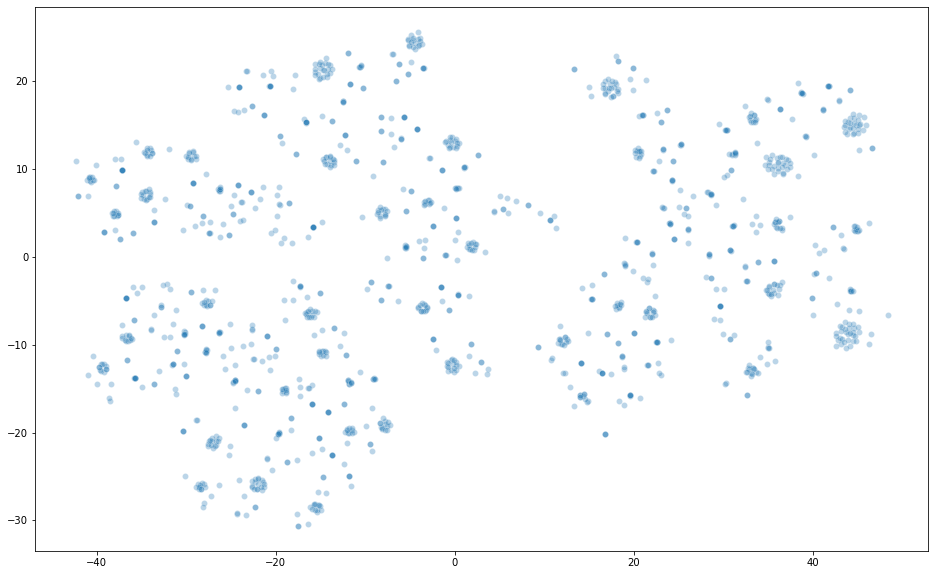

In [21]:
# Scale data
users_train_scaled = pd.DataFrame(data=MinMaxScaler().fit_transform(users_train), index=users_train.index, columns=users_train.columns)

# Calculate t-sne components
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=1000, random_state=RANDOM_STATE, n_jobs=-1)
tsne_results = tsne.fit_transform(users_train_scaled)

# Visualize
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=tsne_results[:, 0], y=tsne_results[:, 1],
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.3
)

### 6.2 Psychological profiles

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1356 samples in 0.001s...
[t-SNE] Computed neighbors for 1356 samples in 0.105s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1356
[t-SNE] Computed conditional probabilities for sample 1356 / 1356
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.916008
[t-SNE] KL divergence after 1000 iterations: 1.440197


<AxesSubplot:>

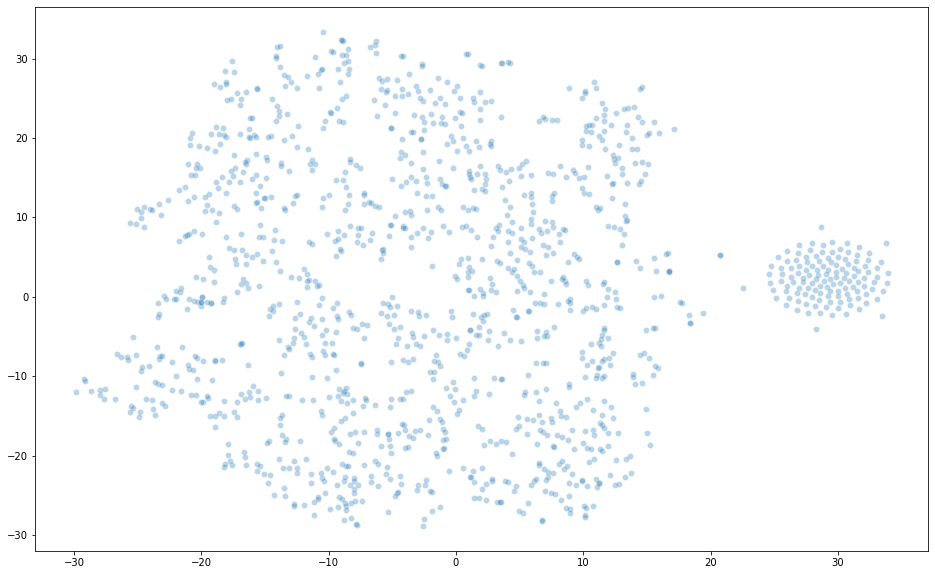

In [22]:
# Scale data
profiles_train_scaled = pd.DataFrame(data=StandardScaler().fit_transform(profiles_train), index=profiles_train.index, columns=profiles_train.columns)

# Calculate t-sne components
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=1000, random_state=RANDOM_STATE, n_jobs=-1)
tsne_results = tsne.fit_transform(profiles_train_scaled)

# Visualize
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=tsne_results[:, 0], y=tsne_results[:, 1],
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.3
)

## 7. Connection between datasets

### 7.1 Config

In [23]:
INPUT_SIZE = users_train.shape[1]
OUTPUT_SIZE = profiles_train.shape[1]

N_EPOCHS = 100
BATCH_SIZE =128
LR = 0.005

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### 7.2 Net, dataloader etc. configuration

In [24]:
# Scale test data
users_test_scaled = pd.DataFrame(data=MinMaxScaler().fit_transform(users_test), index=users_test.index, columns=users_test.columns)

# Merge data
df_train = pd.merge(
    left=users_train_scaled, 
    right=profiles_train,
    how='inner',
    left_index=True,
    right_index=True
)
df_test = pd.merge(
    left=users_test_scaled, 
    right=profiles_test,
    how='inner',
    left_index=True,
    right_index=True
)

# Initialize Datasets
ds_train = UsersProfilesDataset(df_train)
ds_test = UsersProfilesDataset(df_test)

# Initialize Sampler
sampler = torch.utils.data.RandomSampler(ds_train)

# Initialize DataLoader
train_dl = torch.utils.data.DataLoader(ds_train, batch_size=BATCH_SIZE, sampler=sampler)
test_dl = torch.utils.data.DataLoader(ds_test, batch_size=BATCH_SIZE)

# Model params
net = ProfileClassifier(INPUT_SIZE, OUTPUT_SIZE).to(DEVICE)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=LR)

### 7.3 Evaluation function

In [25]:
@torch.no_grad()
def evaluate_model(model, data_loader, print_info=False):
    
    model.eval()
    collect_results = []
    collect_targets = []

    for batch in data_loader:
        X, y = batch
        X = X.float().to(DEVICE)
        y = y.float().to(DEVICE).detach().cpu().numpy()

        pred = model(X)
        collect_results.append(pred.detach().cpu().numpy())
        collect_targets.append(y)

    preds = np.concatenate(collect_results)
    targets = np.concatenate(collect_targets)

    mse = mean_squared_error(targets, preds)

    if print_info:
        print(f'test mse: {mse}')

    model.train()
        
    return mse

### 7.4 Train loop

In [26]:
losses = []
metrics = []

net.to(DEVICE)

for epoch in range(N_EPOCHS):
    print(f'EPOCH={epoch + 1}')
    for X, y in train_dl:
        X = X.float().to(DEVICE)
        y = y.float().to(DEVICE)
        optimizer.zero_grad()
        
        y_pred = net(X)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        
        losses.append(loss.detach().cpu().numpy())
        
    train_ll = evaluate_model(net, train_dl)
    test_ll = evaluate_model(net, test_dl)
    
    print(f'train: loss={train_ll}')
    print(f'test: loss={test_ll}')
          
    metrics.append([train_ll, test_ll])

EPOCH=1
train: loss=0.6282152533531189
test: loss=0.6174966096878052
EPOCH=2
train: loss=0.6160346865653992
test: loss=0.6086410880088806
EPOCH=3
train: loss=0.5951337814331055
test: loss=0.597361147403717
EPOCH=4
train: loss=0.5805712342262268
test: loss=0.5891352295875549
EPOCH=5
train: loss=0.5683728456497192
test: loss=0.5832148790359497
EPOCH=6
train: loss=0.5663539171218872
test: loss=0.5797399282455444
EPOCH=7
train: loss=0.5598191022872925
test: loss=0.5770384669303894
EPOCH=8
train: loss=0.5618401765823364
test: loss=0.5798748731613159
EPOCH=9
train: loss=0.564538836479187
test: loss=0.5803521275520325
EPOCH=10
train: loss=0.5609012246131897
test: loss=0.5766621828079224
EPOCH=11
train: loss=0.5533633232116699
test: loss=0.5729302167892456
EPOCH=12
train: loss=0.5570996999740601
test: loss=0.5756188631057739
EPOCH=13
train: loss=0.5509387254714966
test: loss=0.5728501081466675
EPOCH=14
train: loss=0.5508061647415161
test: loss=0.5713926553726196
EPOCH=15
train: loss=0.54947364

<AxesSubplot:>

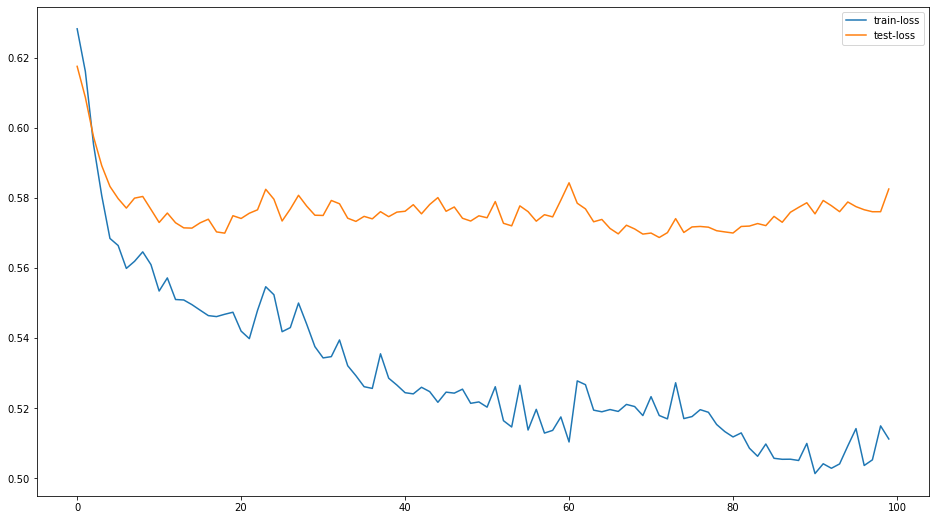

In [27]:
# Plot train/test loss through epochs
%matplotlib inline
pd.DataFrame(metrics, columns=['train-loss','test-loss']).plot(subplots=False, figsize=(16,9))

## 8. Clustering

### 8.1 Data preparation

In [28]:
# Merge train and test results of psychological profiles
profiles_train_scaled = pd.DataFrame(data=StandardScaler().fit_transform(profiles_train), index=profiles_train.index, columns=profiles_train.columns)
profiles_test_scaled = pd.DataFrame(data=StandardScaler().fit_transform(profiles_test), index=profiles_test.index, columns=profiles_test.columns)

profiles_scaled = pd.concat([profiles_train_scaled, profiles_test_scaled], axis=0)

### 8.2 Searching for optimal number of clusters

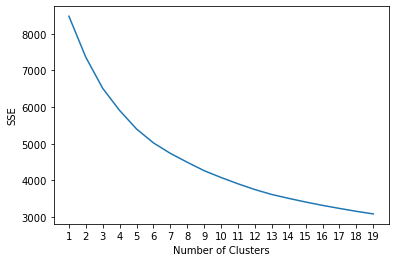

In [29]:
# Set kmeans hyperparameters
kmeans_kwargs = {
    'init': 'random',
    'n_init': 100,
    'max_iter': 2000,
    'random_state': RANDOM_STATE,
}

# Calculate SSE for each k
sse = []
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(profiles_scaled)
    sse.append(kmeans.inertia_)
    
# Plot results
plt.plot(range(1, 20), sse)
plt.xticks(range(1, 20))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

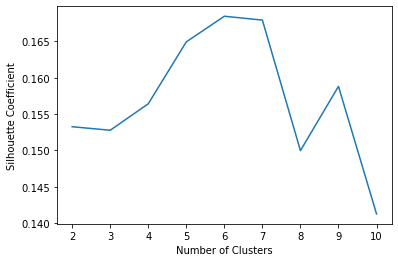

In [30]:
# Calculate silhouette coefficients for each k
silhouette_coefficients = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(profiles_scaled)
    score = silhouette_score(profiles_scaled, kmeans.labels_)
    silhouette_coefficients.append(score)
    
# Plot results
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

### 8.3 Perform clustering

In [31]:
# Perform k-means with optimal number of clusters
k_final = 6
kmeans = KMeans(n_clusters=k_final, **kmeans_kwargs)
kmeans.fit(profiles_scaled)

KMeans(init='random', max_iter=2000, n_clusters=6, n_init=100, random_state=42)

### 8.4 2D visualization of clusters

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1695 samples in 0.001s...
[t-SNE] Computed neighbors for 1695 samples in 0.110s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1695
[t-SNE] Computed conditional probabilities for sample 1695 / 1695
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.789703
[t-SNE] KL divergence after 1000 iterations: 1.487375


<AxesSubplot:>

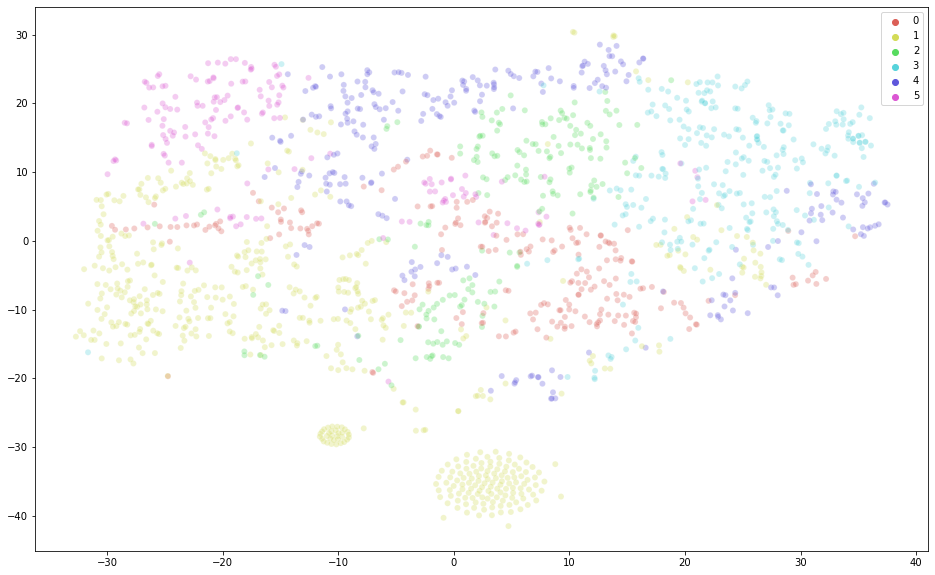

In [32]:
# Calculate t-sne components
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=1000, random_state=RANDOM_STATE, n_jobs=-1)
tsne_results = tsne.fit_transform(profiles_scaled)

# Visualize
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=tsne_results[:, 0], y=tsne_results[:, 1],
    hue=kmeans.labels_,
    palette=sns.color_palette("hls", k_final),
    legend="full",
    alpha=0.3
)

### 8.5 Cluster characteristics

#### 8.5.1 Prepare data

In [36]:
users_not_transformed = pd.concat([users_train_not_transformed, users_test_not_transformed], axis=0)

profiles_scaled['cluster_id'] = kmeans.labels_

df_users_profiles_clust = pd.merge(
    left=users_not_transformed,
    right=profiles_scaled,
    how='inner',
    left_index=True,
    right_index=True
) 

df_users_profiles_clust.head()

,D06,D07,age,browser_version_rank,d01_k,d01_m,d03_1_0,d03_2_0,d03_3_0,d03_4_0,...,browser_name_safari,device_type_desktop,device_type_mobile,device_type_tablet,A,B,C,D,E,cluster_id
UserIdentifier,,,,,,,,,,,,,,,,,,,,,
000d192dc28d1b486121e036a9dbdad6,4.0,3.0,20,6.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,-0.025341,1.116117,1.304589,0.222595,0.029865,4
0013bf1a1aacd3adabe31f48af5c32b5,7.0,4.0,22,25.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.184811,0.786659,2.235974,-0.539499,-0.355921,4
0030705d4aeb43d6bf58cd8df61d4499,3.0,3.0,38,2.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.296980,0.260183,-0.380179,0.318057,-1.138245,1
005644e9eca0b367f9e0dafbdc2eed9f,4.0,3.0,25,7.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.712721,-0.633293,1.286844,2.003100,0.847414,5
005ae7d7a05669373b74fe35a025cdd0,5.0,3.0,35,2.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,2.487183,-1.025761,0.017904,1.829318,0.070779,5


In [ ]:
col_config = {
    'categorical': {
        'D01': 'Gender',
        'D03': 'Education - basic, vocational, secondary, higher education',
        'D04': 'Professional status',
        'D05': 'Size of the city of residence - village, up to 20k, up to 100k, up to 500k, above',
        'D06': 'Financial situation',
        'D07': 'Household size',
        'browser_name': 'Browser name',
        'device_type': 'Device type'
    },
    'continuous': {
        'age': 'Age',
        'browser_version': 'Browser version - simplified'
    }
}

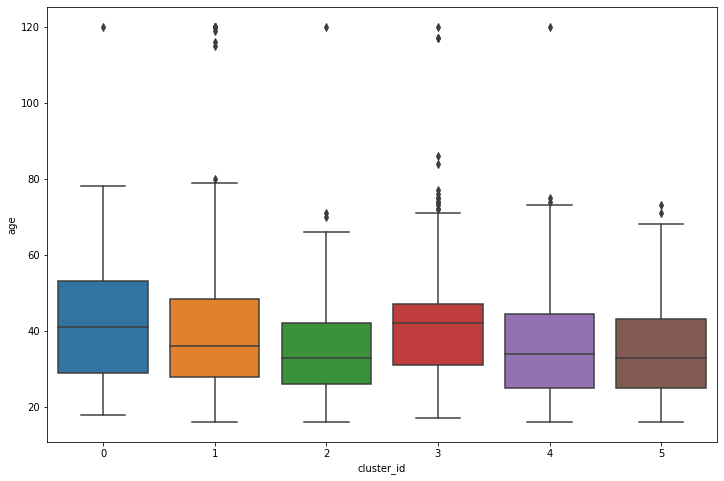

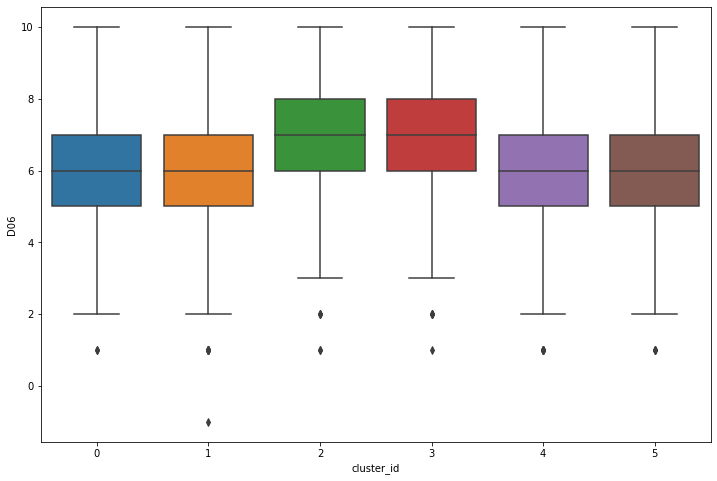

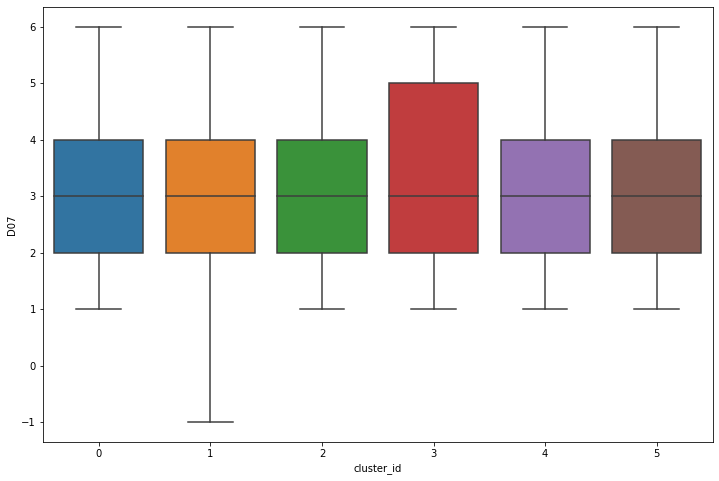

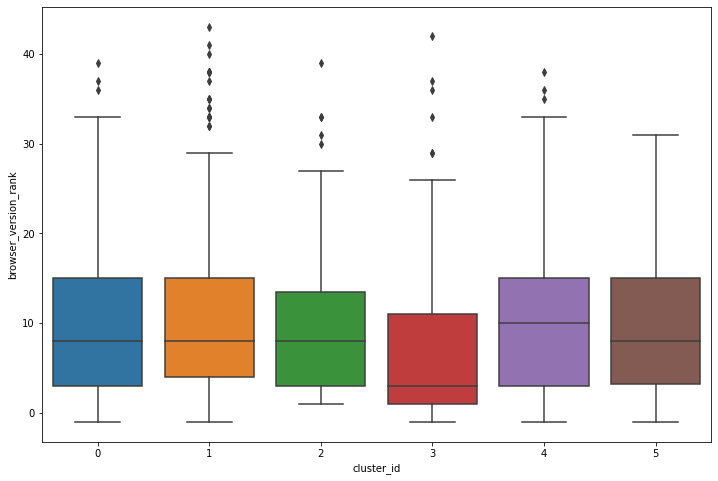

In [42]:
for col_name in ['age', 'D06', 'D07', 'browser_version_rank']:
    plt.figure(figsize=(12,8))
    sns.boxplot(
        data=df_users_profiles_clust,
        x='cluster_id',
        y=col_name
    )
    plt.show()